# Sensitivity Analysis of TKE for Cf-252

In [36]:
import numpy as np
import scipy as sp
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
%matplotlib inline

In [37]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


['histories-vectors.CGMF252CfRT1.25', 'histories-vectors.CGMF252CfRT1.5', 'histories-vectors.CGMF252CfRT0.75', 'histories-vectors.CGMF252CfRT1.0', 'histories-vectors.CGMF252CfRT0.5']
1.25
4.03666666667
1.5
4.01943333333
0.75
4.00593333333
1.0
4.0333
0.5
4.0312


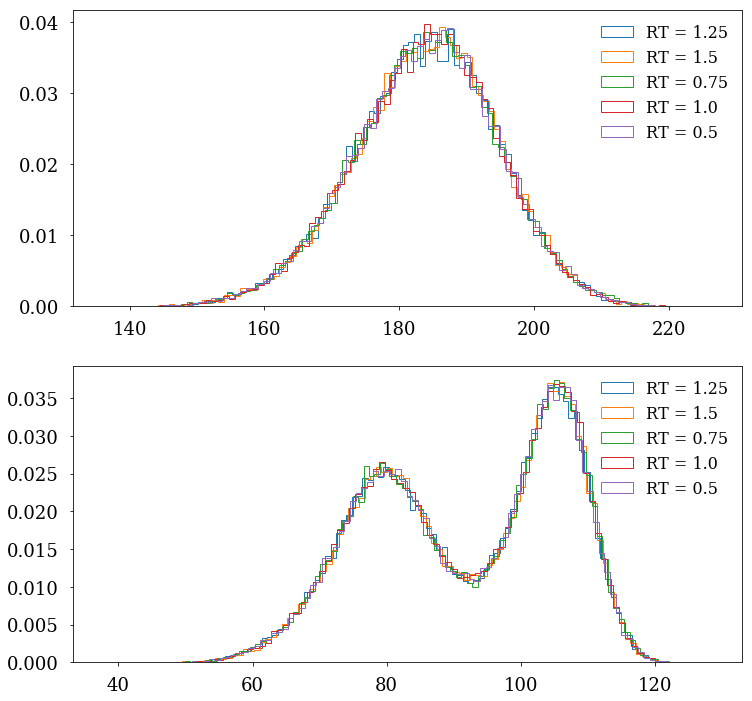

In [38]:
# Special Axis-Sharing Plot

fig, axHist = plt.subplots(figsize=(12,12))

filepath = os.path.join(os.getcwd(),'Cf252RTFiles')

if not os.path.isdir(filepath):
    raise ValueError('You do not have the directory "RTFiles" in your current working directory')

print(os.listdir(filepath))

nnt_mean = []
nn2t_mean = []
nn3t_mean = []
ngt_mean = []
ng2t_mean = []
ng3t_mean = []
TKE_mean = []
TXE_mean = []
Enlab_mean = []
Eglab_mean = []
nhist_arr   = []
RT_arr = []

file_index = 0

for filename in os.listdir(filepath):
    
    RT = float(filename[filename.index('RT')+2:])
    RT_arr.append(RT)

    n_histories = 30000
    nhist_arr.append(n_histories)

    file_loc = os.path.join(filepath,filename)
    working_file = open(file_loc)
    
    # read first line -----------------------------------------------------------------------------------------------
    line = working_file.readline()
    if (line.find("#")!=0):
        sys.exit("ERROR: FIRST LINE OF OUTPUT FILE SHOULD CONTAIN '#'")
        
    # read remainder -----------------------------------------------------------------------------------------------
    nfragments = 0
    
    # re-initialize all arrays
    # Line 1 Arrays of interest

    Ul, Uh, TXE      = [], [], []
#     Jl, Jh, J        = [], [], []
    KEl, KEh, TKE    = [], [], []
    nnl, nnh, nnt    = [], [], []
    ngl, ngh, ngt    = [], [], []

    # Direction/momentum vectors are arranged with CoM first, then Lab
    # Fragment momentum arrays - Line 2
    #Pcml, Pcmh       = [], []
    #Plabl, Plabh     = [], []
    
    # For now, just save the resulting particle energies
    # Neutron Energies - Line 3
    Encml, Encmh     = [], []
    Enlabl, Enlabh   = [], []
    
    # Gamma Energies - Line 4
    Egcml, Egcmh     = [], []
    Eglabl, Eglabh   = [], []
    
    while True:
        line = working_file.readline()
        if (len(line)==0):
            break
        #LINE ONE OF FISSION EVENT (A, Z, U, J, P, KE, nn, ng, nIC)
        nfragments+=1
        tempdata1 = line.split()
        if (nfragments % 2 == 1): # LIGHT FRAGMENT
            Ul.append(float(tempdata1[2]))
#             Jl.append(float(tempdata1[3]))
            KEl.append(float(tempdata1[5]))
            nnl.append(int(tempdata1[6]))
            ngl.append(int(tempdata1[7]))

        else: # HEAVY FRAGMENT
            Uh.append(float(tempdata1[2]))
#             Jh.append(float(tempdata1[3]))
            KEh.append(float(tempdata1[5]))
            nnh.append(int(tempdata1[6]))
            ngh.append(int(tempdata1[7]))

        
        #LINE TWO OF FISSION EVENT (momentum vector in Lab and center of mass of FRAGMENT)
        line = working_file.readline()
        tempdata2 = line.split()
        # for now, don't worry about line 2
        
        #LINE THREE OF FISSION EVENT (Neutron direction cosines and energies, Lab and center of mass respectively)
        if (int(tempdata1[6]) != 0):
            line = working_file.readline()
            tempdata3 = line.split()
            if (nfragments % 2 == 1): # LIGHT FRAGMENT
                for i in range(int(tempdata1[6])):
                    Encml.append(float(tempdata3[4*i + 7]))
                    Enlabl.append(float(tempdata3[8*i + 7]))
            else: # HEAVY FRAGMENT
                for i in range(int(tempdata1[6])):
                    Encmh.append(float(tempdata3[4*i + 7]))
                    Enlabh.append(float(tempdata3[8*i + 7]))
            
        
        #LINE FOUR OF FISSION EVENT (Gamma direction cosines and energies, Lab and center of mass respectively)
        if (int(tempdata1[7]) != 0):
            line = working_file.readline()
            tempdata4 = line.split()
            if (nfragments % 2 == 1): # LIGHT FRAGMENT
                for i in range(int(tempdata1[7])):
                    Egcml.append(float(tempdata4[4*i + 7]))
                    Eglabl.append(float(tempdata4[8*i + 7]))
            else: # HEAVY FRAGMENT
                for i in range(int(tempdata1[7])):
                    Egcmh.append(float(tempdata4[4*i + 7]))
                    Eglabh.append(float(tempdata4[8*i + 7]))
        
#         if (nfragments>=MaxHistories*2):
#             break
#     nhistories = nfragments/2
    
    # Concatenate arrays
    TXE    = np.sum([Ul , Uh], axis=0)
#     J      = Jl + Jh
    TKE    = np.sum([KEl , KEh], axis=0)
    nnt    = np.sum([nnl , nnh], axis=0)
    nn2t   = [float(nnt[i] * (nnt[i]-1)) for i in range(len(nnt))] # 2nd factorial moment
    nn3t   = [float(nnt[i] * (nnt[i]-1) * (nnt[i]-2)) for i in range(len(nnt))] # 3rd factorial moment
    ngt    = np.sum([ngl , ngh], axis=0)
    ng2t   = [float(ngt[i] * (ngt[i]-1)) for i in range(len(ngt))]
    ng3t   = [float(ngt[i] * (ngt[i]-1) * (ngt[i]-2)) for i in range(len(ngt))]
    Encm  = Encml + Encmh
    Egcm  = Egcml + Egcmh
    Enlab = Enlabl + Enlabh
    Eglab = Eglabl + Eglabh
    
    # Close File that is read
    working_file.close()
    
    print(RT)
    print(mean(nnt.astype(float)))
    
    nnt_mean.append(mean(nnt.astype(float)))
    ngt_mean.append(mean(ngt.astype(float)))
    TKE_mean.append(mean(TKE.astype(float)))
    TXE_mean.append(mean(TXE.astype(float)))
    Enlab_mean.append(mean(Enlab))
    Eglab_mean.append(mean(Eglab))
    nn2t_mean.append(mean(nn2t))
    nn3t_mean.append(mean(nn3t))
    ng2t_mean.append(mean(ng2t))
    ng3t_mean.append(mean(ng3t))
    
    # Make a histogram plot each iteration
    plt.subplot(2,1,1)
    plt.hist(TKE, bins=100, histtype = 'step', label = 'RT = {}'.format(RT), normed = True)
    lg = plt.legend(numpoints=1,fontsize=16,loc='best')
    lg.draw_frame(False)
    plt.subplot(2,1,2)
    plt.hist((KEl+KEh), bins=100, histtype = 'step', label = 'RT = {}'.format(RT), normed = True)
    lg = plt.legend(numpoints=1,fontsize=16,loc='best')
    lg.draw_frame(False)


[ -0.1085165   23.97256614]


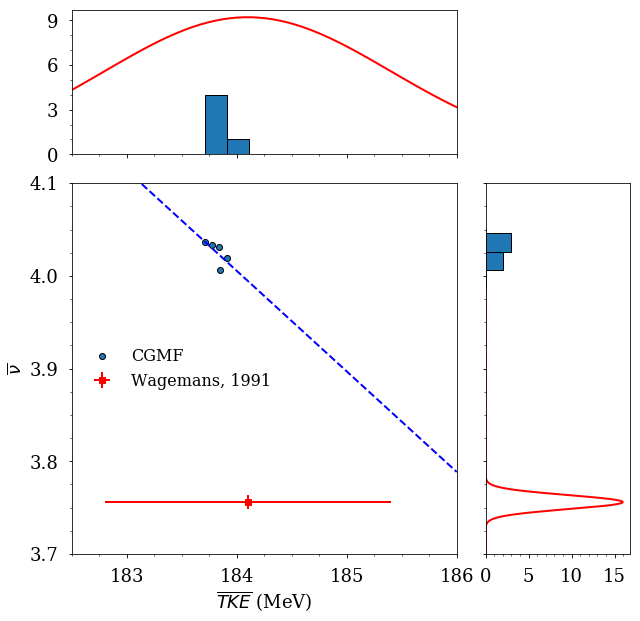

In [39]:
# Special Axis-Sharing Plot

fig, axScatter = plt.subplots(figsize=(10,10))

# the scatter plot:
sz = 8
axScatter.scatter(TKE_mean, nnt_mean, edgecolor='k',label="CGMF")
axScatter.set_aspect('auto')
axScatter.set_xlabel(r"$\overline{TKE}$ (MeV)")
axScatter.set_ylabel(r'$\overline{\nu}$')
axScatter.xaxis.set_major_locator(ticker.MultipleLocator(1))
axScatter.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
axScatter.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
axScatter.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))

fit = np.polyfit(TKE_mean,nnt_mean,1)
print (fit)
fitfun = np.poly1d(fit)
x=np.linspace(182,186,61)
axScatter.plot(x,fitfun(x),'b--')
axScatter.errorbar(184.1,3.756,xerr=1.3,yerr=0.002*3.756,fmt='rs',label='Wagemans, 1991') #-- experimental point
lg = plt.legend(numpoints=1,fontsize=16,loc='center left')
lg.draw_frame(False)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 2., pad=0.4, sharex=axScatter)
axHisty = divider.append_axes("right", 2., pad=0.4, sharey=axScatter)

# make some labels invisible
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
         visible=False)

# now determine nice limits by hand:
xbinwidth = 0.2
ybinwidth = 0.02

xbins = np.arange(np.min(TKE_mean) - xbinwidth, np.max(TKE_mean) + xbinwidth, xbinwidth)
ybins = np.arange(np.min(nnt_mean) - ybinwidth, np.max(nnt_mean) + ybinwidth, ybinwidth)

axHistx.hist(TKE_mean, bins=xbins,edgecolor = 'k')
axHisty.hist(nnt_mean, bins=ybins, orientation='horizontal',edgecolor = 'k')

mean_TKE_exp = 184.1
sig_TKE_exp  = 1.3
axHistx.plot(x,30*mlab.normpdf(x, mean_TKE_exp, sig_TKE_exp), 'r')

mean_nu_exp  = 3.756
sig_nu_exp   = 0.002*3.756
y        = np.linspace(3.6,4.05,1000)
plt.plot(0.3*mlab.normpdf(y, mean_nu_exp, sig_nu_exp), y, 'r')

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
for tl in axHistx.get_xticklabels():
    tl.set_visible(False)
axHistx.yaxis.set_major_locator(ticker.MultipleLocator(3))
axHistx.yaxis.set_minor_locator(ticker.MultipleLocator(1))

#axHisty.axis["left"].major_ticklabels.set_visible(False)
for tl in axHisty.get_yticklabels():
    tl.set_visible(False)
axHisty.xaxis.set_major_locator(ticker.MultipleLocator(5))
axHisty.xaxis.set_minor_locator(ticker.MultipleLocator(1))

axScatter.set_ylim([3.7, 4.1])
axScatter.set_xlim([182.5, 186.])

plt.draw()
plt.show()

[-0.00906667  0.02101333  4.01449333]


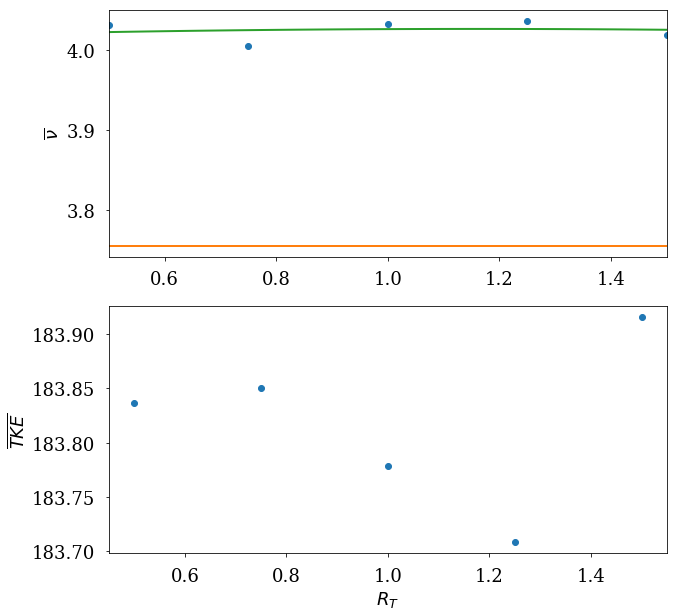

In [42]:
fig = plt.subplots(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(RT_arr, nnt_mean,'o')
plt.ylabel(r'$\overline{\nu}$')
plt.xlim(0.5,1.5)
plt.plot([0.5, 1.5], [3.756, 3.756])
x = np.linspace(0.5,1.5,100)
z = np.polyfit(RT_arr, nnt_mean, 2)
print(z)
p = np.poly1d(z)
plt.plot(x, p(x))

plt.subplot(2,1,2)
plt.plot(RT_arr,TKE_mean,'o')
plt.ylabel(r'$\overline{TKE}$')
plt.xlabel(r'$R_{T}$')

[-0.18731429  0.37805524  9.17853333]


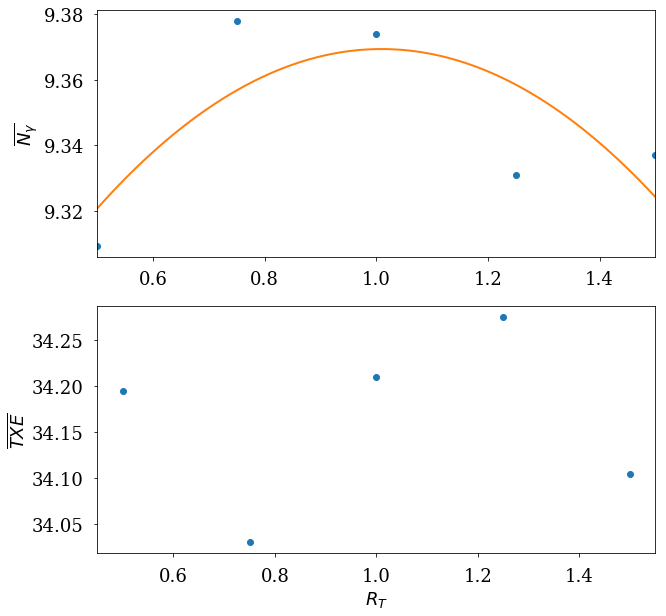

In [41]:
fig = plt.subplots(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(RT_arr, ngt_mean,'o')
plt.ylabel(r'$\overline{N_{\gamma}}$')
plt.xlim(0.5,1.5)
x = np.linspace(0.5,1.5,100)
z = np.polyfit(RT_arr, ngt_mean, 2)
print(z)
p = np.poly1d(z)
plt.plot(x, p(x))

plt.subplot(2,1,2)
plt.plot(RT_arr,TXE_mean,'o')
plt.ylabel(r'$\overline{TXE}$')
plt.xlabel(r'$R_{T}$')